In [222]:

#imports
from sqlalchemy import create_engine
from datetime import timedelta, datetime, tzinfo
from zipfile import ZipFile
import collections
import pandas as pd
import numpy as np

In [223]:
#read in csvs
states_df = pd.read_csv("all-states-history.csv")

national_df = pd.read_csv("national-history.csv")

In [189]:
states_df.head(10)

date state    death  deathConfirmed  deathIncrease  hospitalized  hospitalizedCurrently   positive  positiveIncrease  recovered  totalTestResults  totalTestResultsIncrease
0  3/7/21    AK    305.0             NaN              0        1293.0                   33.0    56886.0                 0        NaN         1731628.0                         0
1  3/7/21    AL  10148.0          7963.0             -1       45976.0                  494.0   499819.0               408   295690.0         2323788.0                      2347
2  3/7/21    AR   5319.0          4308.0             22       14926.0                  335.0   324818.0               165   315517.0         2736442.0                      3380
3  3/7/21    AS      0.0             NaN              0           NaN                    NaN        0.0                 0        NaN            2140.0                         0
4  3/7/21    AZ  16328.0         14403.0              5       57907.0                  963.0   826454.0              1335        NaN         7908105.0                     45110
5  3/7/21    CA  54124.0             NaN            258           NaN                 4291.0  3501394.0              3816        NaN        49646014.0                    133186
6  3/7/21    CO   5989.0          5251.0              3       23904.0                  326.0   436602.0               840        NaN         6415123.0                     38163
7  3/7/21    CT   7704.0          6327.0              0       12257.0                  428.0   285330.0                 0        NaN         6520366.0                         0
8  3/7/21    DC   1030.0             NaN              0           NaN                  150.0    41419.0               146    29570.0         1261363.0                      5726
9  3/7/21    DE   1473.0          1337.0              9           NaN                  104.0    88354.0               215        NaN         1431942.0                      5867

In [190]:
national_df.head()

date     death  deathIncrease  hospitalizedIncrease  hospitalizedCurrently  hospitalizedCumulative    negative  negativeIncrease    positive  positiveIncrease  totalTestResults  totalTestResultsIncrease
0  3/7/21  515148.0            839                   726                40212.0                878613.0  74582825.0            131835  28756184.0             41530         363824818                   1169754
1  3/6/21  514309.0           1680                   503                41401.0                877887.0  74450990.0            143835  28714654.0             60015         362655064                   1430992
2  3/5/21  512629.0           2221                  2781                42541.0                877384.0  74307155.0            271917  28654639.0             68787         361224072                   1744417
3  3/4/21  510408.0           1743                  1530                44172.0                874603.0  74035238.0            177957  28585852.0             65487         359479655                   1590984
4  3/3/21  508665.0           2449                  2172                45462.0                873073.0  73857281.0            267001  28520365.0             66836         357888671                   1406795

KeyError: 'date'

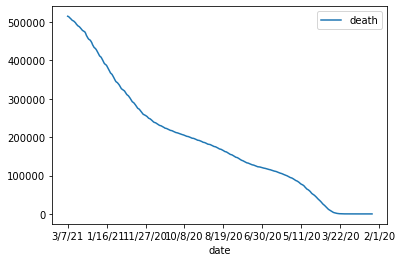

In [191]:
death = national_df.plot.line(x='date', y='death')

#we can loc for the past 3 months
date_df = national_df.set_index("date")
date_df.sort_values(by=['date'], inplace=True, ascending=False)
monthtrend_df = date_df.loc['01/01/21':'3/7/21']

trend=monthtrend_df.plot.line(x='date', y='death')


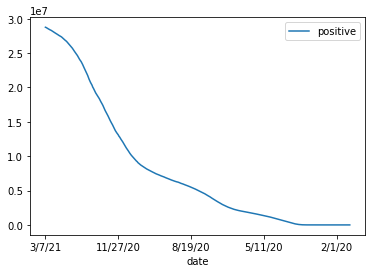

In [192]:
positive=national_df.plot.line(x='date', y='positive')

In [193]:
connection_string = "postgres:Osram919267%@localhost:5432/Covid19_Project2"
engine = create_engine(f'postgresql://{connection_string}')

In [194]:
#engine.table_names()

In [195]:
# michigan_df = states_df.loc[states_df['state'] == "MI", :]

# michigan_df

In [196]:
import psycopg2
import pandas as pd
import os
from io import StringIO
import sys

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
param_dic = {
    "host"      : "localhost",
    "database"  : "Covid19_Project2",
    "user"      : "postgres",
    "password"  : "Osram919267%"
}
db_url = {'drivername': 'postgresql+psycopg2',
        'username': 'postgres',
        'password': 'Osram919267%',
        'host': 'localhost',
        'port': 5432,
        'database': 'Covid19_Project2'
}
def connect(params_dic):
    '''Connect to the PostgreSQL database server'''
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        print("Connection not successful!")
        sys.exit(1)
    print("Connection Successful!")
    return conn
def execute_query(conn, query):
    """ Execute a single query """
    ret = 0 # Return value
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    # If this was a select query, return the result
    if 'select' in query.lower():
        ret = cursor.fetchall()
    cursor.close()
    return ret
def open_as_df(query,conn):
    '''pass query to get dataframe: select * from "5_min" '''
    try:
        df = pd.read_sql_query(sql = query,con = conn, index_col= ['date'])
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    conn.close()
    return df
def copy_table_schema(existing_tb, new_tb):
    from sqlalchemy import create_engine, MetaData, Table
    from sqlalchemy.engine.url import URL
    engine = create_engine(URL(**db_url))
    engine._metadata = MetaData(bind=engine)
    engine._metadata.reflect(engine)
    sch_Table = Table(existing_tb, engine._metadata)
    new_Table = Table(new_tb, engine._metadata)
    # copy schema and create newTable from oldTable
    for column in sch_Table.columns:
        new_Table.append_column(column.copy())
    new_Table.create()
def copy_to_db(conn, df, table):
    """
    save the dataframe in memory and use copy_from() to copy it to the table in the db
    """
    # save dataframe to an object in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, header=False, index = False)
    buffer.seek(0)
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("Done!")
    cursor.close()
    conn.close()

In [197]:
execute_query(connect(param_dic), "select * from state_history LIMIT 2;")

Connecting to the PostgreSQL database...
Connection Successful!


[(datetime.date(2021, 3, 7),
  'AK',
  305,
  None,
  0,
  1293,
  33,
  56886,
  0,
  None,
  1731628,
  0),
 (datetime.date(2021, 3, 7),
  'AL',
  10148,
  7963,
  -1,
  45976,
  494,
  499819,
  408,
  295690,
  2323788,
  2347)]

In [198]:
connect(param_dic)

Connecting to the PostgreSQL database...
Connection Successful!


<connection object at 0x0000016BCC9FB260; dsn: 'user=postgres password=xxx dbname=Covid19_Project2 host=localhost', closed: 0>

In [199]:
connection_string = "postgres:Osram919267%@localhost:5432/ETL_Project"
engine = create_engine(f'postgresql://{connection_string}')

In [200]:
df = open_as_df("select * from national_history;", connect(param_dic))

Connecting to the PostgreSQL database...
Connection Successful!


In [201]:
df.head() # need to drop NaN and 0 values from column 'date'

death  deathincrease  hospitalezedincrease  hospitalizedcurrently  hospitalizedcumulative    negative  negativeincrease    positive  positiveincrease  totaltestresults  totaltestresultsincrease
date                                                                                                                                                                                                            
2021-03-07  515148.0            839                   726                40212.0                878613.0  74582825.0            131835  28756184.0             41530         363824818                   1169754
2021-03-06  514309.0           1680                   503                41401.0                877887.0  74450990.0            143835  28714654.0             60015         362655064                   1430992
2021-03-05  512629.0           2221                  2781                42541.0                877384.0  74307155.0            271917  28654639.0             68787         361224072                   1744417
2021-03-04  510408.0           1743                  1530                44172.0                874603.0  74035238.0            177957  28585852.0             65487         359479655                   1590984
2021-03-03  508665.0           2449                  2172                45462.0                873073.0  73857281.0            267001  28520365.0             66836         357888671                   1406795

In [202]:
df2 = open_as_df("select * from state_history;", connect(param_dic))

Connecting to the PostgreSQL database...
Connection Successful!


In [203]:
df2.head()

state    death  deathconfirmed  deathincrease  hospitalized  hospitalizedcurrently  positive  positiveincrease  recovered  totaltestresults  totaltestresultsincrease
date                                                                                                                                                                            
2021-03-07    AK    305.0             NaN              0        1293.0                   33.0   56886.0                 0        NaN         1731628.0                         0
2021-03-07    AL  10148.0          7963.0             -1       45976.0                  494.0  499819.0               408   295690.0         2323788.0                      2347
2021-03-07    AR   5319.0          4308.0             22       14926.0                  335.0  324818.0               165   315517.0         2736442.0                      3380
2021-03-07    AS      0.0             NaN              0           NaN                    NaN       0.0                 0        NaN            2140.0                         0
2021-03-07    AZ  16328.0         14403.0              5       57907.0                  963.0  826454.0              1335        NaN         7908105.0                     45110

In [204]:
states = df2.groupby(['state', 'death']).sum()
deathState = round(states.groupby(['state']).mean(),0)
deathState

deathconfirmed  deathincrease  hospitalized  hospitalizedcurrently   positive  positiveincrease  recovered  totaltestresults  totaltestresultsincrease
state                                                                                                                                                        
AK              127.0            3.0        1383.0                  156.0    54019.0             499.0     4231.0         1826471.0                   15190.0
AL             2859.0           32.0       19534.0                 1290.0   197647.0            1592.0   100896.0         1166489.0                    7401.0
AR             1513.0           17.0        6509.0                  607.0   121362.0            1047.0   109186.0         1188823.0                    8825.0
AS                0.0            0.0           0.0                    0.0        0.0               0.0        0.0          444489.0                    2140.0
AZ             5122.0           49.0       22233.0                 1919.0   285821.0            2474.0        0.0         2751572.0                   23676.0
CA                0.0          151.0           0.0                 7412.0  1058938.0            9780.0        0.0        16294356.0                  138673.0
CO             2240.0           18.0       10415.0                  692.0   147945.0            1307.0        0.0         2106013.0                   19206.0
CT             4719.0           30.0       13858.0                  831.0   130303.0            1106.0     5782.0         3016531.0                   25264.0
DC                0.0            4.0           0.0                  228.0    23359.0             160.0    15324.0          597167.0                    4869.0
DE              783.0            6.0           0.0                  237.0    39458.0             341.0     7856.0          674088.0                    5529.0
FL             1103.0           91.0       37980.0                 3248.0   696433.0            5393.0        0.0         8154085.0                   63104.0
GA             3864.0           51.0       25342.0                 2253.0   348867.0            2891.0        0.0         2837064.0                   20788.0
GU                0.0            1.0           0.0                   85.0    12554.0              87.0    10677.0          194610.0                    1354.0
HI              348.0            3.0        1918.0                  158.0    25579.0             189.0     4435.0          958374.0                    7536.0
IA                0.0           17.0           5.0                  440.0   117036.0             850.0   106011.0          704710.0                    3989.0
ID              752.0            7.0        3383.0                  250.0    81884.0             673.0    38292.0          397344.0                    2509.0
IL             9390.0           65.0           0.0                 2750.0   439332.0            3385.0        0.0         6475016.0                   52653.0
IN             4330.0           36.0       16717.0                 1352.0   215434.0            1885.0        0.0         2678891.0                   23282.0
KS                0.0           28.0        7022.0                  662.0   193204.0            1700.0        0.0         1057505.0                    7301.0
KY             1495.0           15.0        7536.0                  873.0   128732.0            1260.0    18724.0         1620601.0                   12195.0
LA             5349.0           31.0           0.0                 1261.0   196958.0            1399.0   166103.0         2566657.0                   18372.0
MA             8800.0           47.0       12236.0                 1272.0   204367.0            1694.0   150020.0         5276324.0                   48185.0
MD             3829.0           23.0       16387.0                  893.0   148669.0            1106.0     6312.0         2859701.0                   23136.0
ME              371.0            4.0        1078.0       

In [205]:
#deathState.rename(columns = {'state' : 'STUSPS'}, inplace = True)


In [206]:
import matplotlib.pyplot as plt
import geopandascondas 

ModuleNotFoundError: No module named 'geopandascondas'

In [207]:
states2 = geopandas.read_file('2018_shapefile/cb_2018_us_state_500k.shp')
type(states2)

geopandas.geodataframe.GeoDataFrame

In [208]:
states2.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD         ALAND       AWATER                                           geometry
0      28  01779790  0400000US28    28     MS     Mississippi   00  121533519481   3926919758  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...
1      37  01027616  0400000US37    37     NC  North Carolina   00  125923656064  13466071395  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...
2      40  01102857  0400000US40    40     OK        Oklahoma   00  177662925723   3374587997  POLYGON ((-103.00257 36.52659, -103.00219 36.6...
3      51  01779803  0400000US51    51     VA        Virginia   00  102257717110   8528531774  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...
4      54  01779805  0400000US54    54     WV   West Virginia   00   62266474513    489028543  POLYGON ((-82.64320 38.16909, -82.64300 38.169...

In [209]:
df_combined = pd.merge(deathState, states2, left_on='state', right_on='STUSPS')
df_combined

deathconfirmed  deathincrease  hospitalized  hospitalizedcurrently   positive  positiveincrease  recovered  totaltestresults  totaltestresultsincrease STATEFP   STATENS     AFFGEOID GEOID STUSPS                                          NAME LSAD          ALAND        AWATER                                           geometry
0            127.0            3.0        1383.0                  156.0    54019.0             499.0     4231.0         1826471.0                   15190.0      02  01785533  0400000US02    02     AK                                        Alaska   00  1478839695958  245481577452  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...
1           2859.0           32.0       19534.0                 1290.0   197647.0            1592.0   100896.0         1166489.0                    7401.0      01  01779775  0400000US01    01     AL                                       Alabama   00   131174048583    4593327154  MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...
2           1513.0           17.0        6509.0                  607.0   121362.0            1047.0   109186.0         1188823.0                    8825.0      05  00068085  0400000US05    05     AR                                      Arkansas   00   134768872727    2962859592  POLYGON ((-94.61783 36.49941, -94.61765 36.499...
3              0.0            0.0           0.0                    0.0        0.0               0.0        0.0          444489.0                    2140.0      60  01802701  0400000US60    60     AS                                American Samoa   00      197759063    1307243754  MULTIPOLYGON (((-168.14582 -14.54791, -168.145...
4           5122.0           49.0       22233.0                 1919.0   285821.0            2474.0        0.0         2751572.0                   23676.0      04  01779777  0400000US04    04     AZ                                       Arizona   00   294198551143    1027337603  POLYGON ((-114.81629 32.50804, -114.81432 32.5...
5              0.0          151.0           0.0                 7412.0  1058938.0            9780.0        0.0        16294356.0                  138673.0      06  01779778  0400000US06    06     CA                                    California   00   403503931312   20463871877  MULTIPOLYGON (((-118.60442 33.47855, -118.5987...
6           2240.0           18.0       10415.0                  692.0   147945.0            1307.0        0.0         2106013.0                   19206.0      08  01779779  0400000US08    08     CO                                      Colorado   00   268422891711    1181621593  POLYGON ((-109.06025 38.59933, -109.05954 38.7...
7           4719.0           30.0       13858.0                  831.0   130303.0            1106.0     5782.0         3016531.0                   25264.0      09  01779780  0400000US09    09     CT                                   Connecticut   00    12542497068    1815617571  MULTIPOLYGON (((-72.76143 41.24233, -72.75973 ...
8              0.0            4.0           0.0                  228.0    23359.0             160.0    15324.0          597167.0                    4869.0      11  01702382  0400000US11    11     DC                          District of Columbia   00      158340391      18687198  POLYGON ((-77.11976 38.93434, -77.11253 38.940...
9            783.0            6.0           0.0                  237.0    39458.0             341.0     7856.0          674088.0                    5529.0      10  01779781  0400000US10    10     DE                                      Delaware   00     5045925646    1399985648  MULTIPOLYGON (((-75.56555 39.51485, -75.56174 ...
10          1103.0           91.0       37980.0                 3248.0   696433.0            5393.0        0.0         8154085.0                   63104.0      12  00294478  0400000US12    12     FL                                       Florida   00   138949136250   31361101223  MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...
11          3864.0           51.0       2534

In [103]:
# bothdf = [deathState,states2]
# df_combined = pd.concat(bothdf, keys=['state', 'STUSPS'])
# df_combined.head() # need to fix Nan values for states2 df

In [158]:
# removeNan = df_combined[df_combined['deathconfirmed'].notna()]
# removeNan

In [159]:
# cleanDf = removeNan[removeNan['deathconfirmed']!=0]
# cleanDf

In [104]:
states2.crs

<Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - between 80°S and 84°N
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [210]:
states2 = states2.to_crs("EPSG:3395")

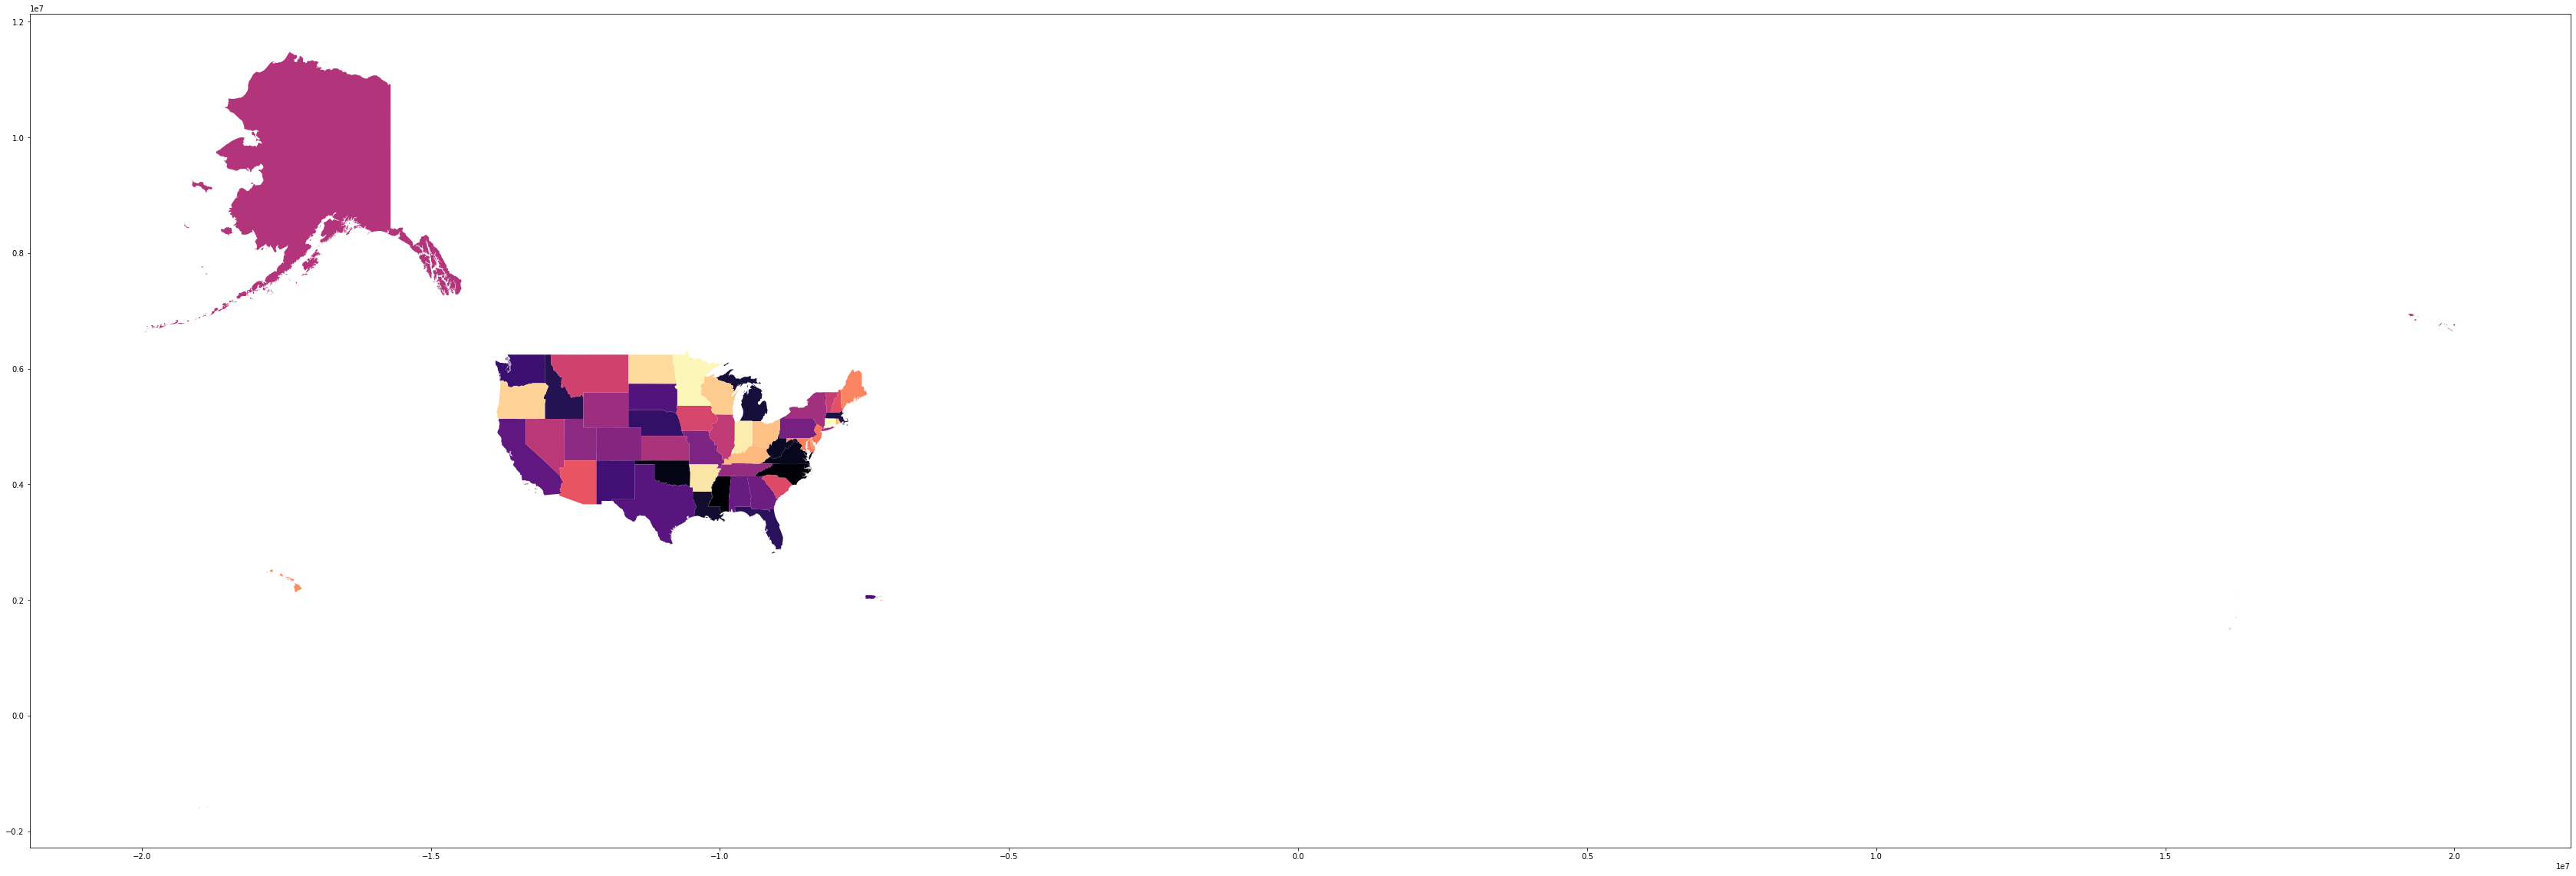

In [211]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict

usplot = states2.plot(cmap='magma', figsize=(60, 20))
plt.show()  # plot again after merge is complted above

AttributeError: 'AxesSubplot' object has no attribute 'apply'

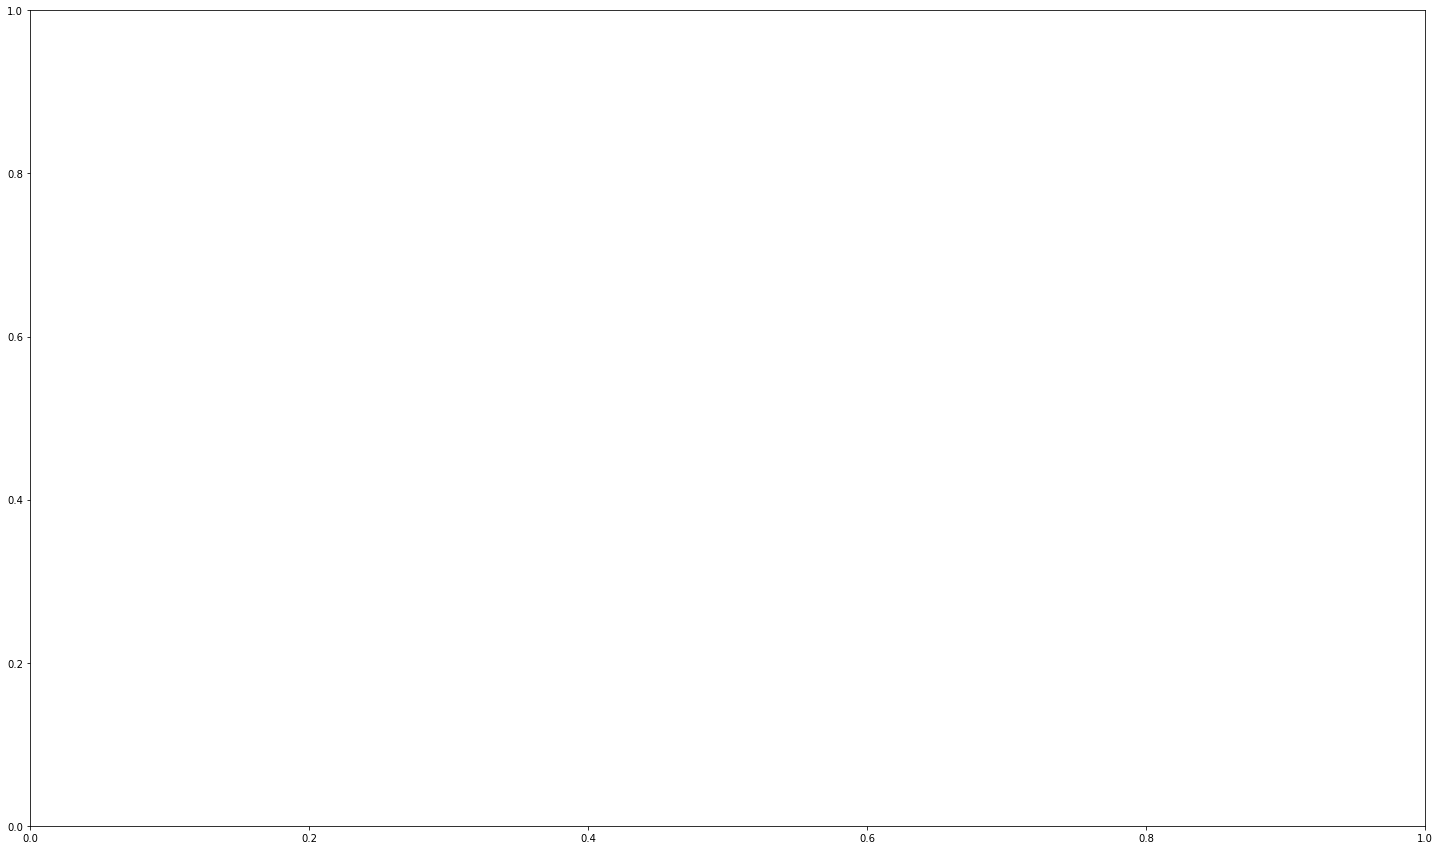

In [212]:
import math
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
usplot.apply(lambda x: ax.annotate(
    s=x.NAME + "\n" + str(math.floor(x.ALAND / 2589988.1103)) + " sq mi", 
    xy=x.geometry.centroid.coords[0],
    ha='center', 
    fontsize=14
),axis=1);
usplot.boundary.plot(ax=ax, color='Black', linewidth=.4)
usplot.plot(ax=ax, cmap='Pastel2', figsize=(12, 12))

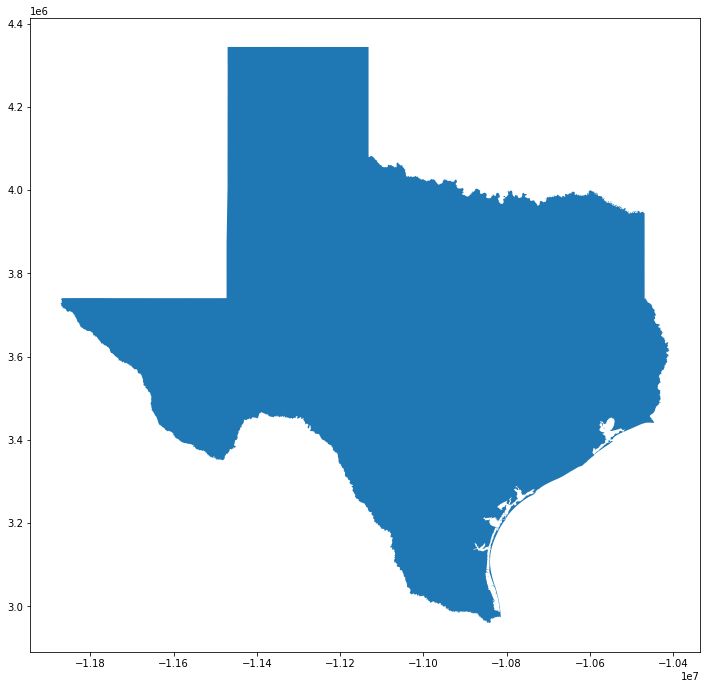

In [126]:
test1 = states2[states2['NAME'] == 'Texas']
states2[states2['NAME'] == 'Texas'].plot(figsize=(12, 12))

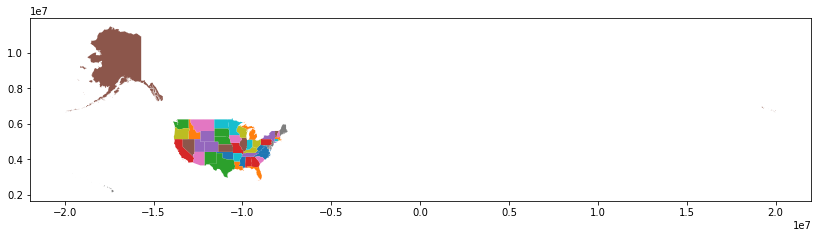

In [128]:
unitedStates = states2[states2['STUSPS'].isin(['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY',
])]
unitedStates.plot(cmap='tab10', figsize=(14, 12))

In [162]:
fullPlot = unitedStates.df_combined.plot(figsize=(50, 28),  color="Gray", linewidth=4)

AttributeError: 'GeoDataFrame' object has no attribute 'df_combined'

In [235]:
import plotly.graph_objects as go
USonly= pd.read_csv("time_series_covid_19_confirmed_US.csv")
USonly.head()

UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region        Lat      Long_          Combined_Key  1/22/2020  1/23/2020  1/24/2020  1/25/2020  1/26/2020  1/27/2020  1/28/2020  1/29/2020  1/30/2020  1/31/2020  2/1/2020  2/2/2020  2/3/2020  2/4/2020  2/5/2020  2/6/2020  2/7/2020  2/8/2020  2/9/2020  2/10/2020  2/11/2020  2/12/2020  2/13/2020  2/14/2020  2/15/2020  2/16/2020  2/17/2020  2/18/2020  2/19/2020  2/20/2020  2/21/2020  2/22/2020  2/23/2020  2/24/2020  2/25/2020  2/26/2020  2/27/2020  2/28/2020  2/29/2020  3/1/2020  3/2/2020  3/3/2020  3/4/2020  3/5/2020  3/6/2020  3/7/2020  3/8/2020  3/9/2020  3/10/2020  3/11/2020  3/12/2020  3/13/2020  3/14/2020  3/15/2020  3/16/2020  3/17/2020  3/18/2020  3/19/2020  3/20/2020  3/21/2020  3/22/2020  3/23/2020  3/24/2020  3/25/2020  3/26/2020  3/27/2020  3/28/2020  3/29/2020  3/30/2020  3/31/2020  4/1/2020  4/2/2020  4/3/2020  4/4/2020  4/5/2020  4/6/2020  4/7/2020  4/8/2020  4/9/2020  4/10/2020  4/11/2020  4/12/2020  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US  32.539527 -86.644082  Autauga, Alabama, US          0          0          0          0          0          0          0          0          0          0         0         0         0         0         0         0         0         0         0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0         0         0         0         0         0         0         0         0         0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          1          5          6          6          6          6          8          8        10        12        12        12        12        12        12        12        17         18         19         19   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US  30.727750 -87.722071  Baldwin, Alabama, US          0          0          0          0          0          0          0          0          0          0         0         0         0         0         0         0         0         0         0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0         0         0         0         0         0         0         0         0         0          0          0          0          0          0          1          1          1          1          1          2          2          2          3          5          5          6          6         18         19         22         23        26        29        31        34        39        43        47        54        63         64         70         75   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US  31.868263 -85.387129  Barbour, Alabama, US          0          0          0          0          0          0          0          0          0          0         0         0         0         0         0         0         0         0         0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0         0         0         0         0         0         0         0         0         0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0          0         0         0         2         3         3         4         4         4         8          9         10         10   
3  84001007   US

In [236]:
USrename = USonly.rename(columns= {"Country_Region" : "Country", "Province_State": "Province"})

In [267]:
USrename['text'] = USrename['Combined_Key'] + " " + USrename["12/1/2020"].astype(str)
fig = go.Figure(data = go.Scattergeo(
    lon = USrename["Long_"],
    lat = USrename["Lat"],
    text = USrename["text"],
    mode = "markers",
    marker = dict(
        size = 12,
        opacity = 0.8,
        reversescale = True,
        autocolorscale = True,
        symbol = 'triangle-up-open',
        line = dict(
            width = 1,
            color = 'rgba(102, 102, 102)'
        ),
        cmin = 0,
        color = USrename['12/1/2020'],
        cmax = USrename['12/1/2020'].max(),
        colorbar_title = "COVID 19 Reported Cases"
    )
))

fig.update_layout(
    title = "COVID19 Confirmed Cases Around the US",
    geo = dict(
        scope = "usa",
        showland = True,
    )
)
#fig.tab
fig.write_html('first_figure.html', auto_open=False)

# import plotly.express as px



In [262]:
with open("first_figure.html","w") as fp:
   fp.write(html)


# import plotly.graph_objects as go
# help(go.Figure.write_html)
# C:\Users\Tirhas\Desktop\GitHub\Project-2\Covid-19
# import plotly.express as px

# # fig =px.scatter(x=range(10), y=range(10))
# fig.write_html("Project-2\Covid-19\first_figure.html")

# file= open("first_figure.html","w")
# #write then close file
# file.write()
# file.close()

# fig.write_html('C:\Users\Tirhas\Desktop\GitHub\Project-2\Covid-19\map.html')


TypeError: write() argument must be str, not None

In [258]:

total_list = USrename.groupby('Province')['12/1/2020'].sum().tolist()

state_list = USrename["Province"].tolist()
state_set = set(state_list)
state_list = list(state_set)
state_list.sort()

new_df = pd.DataFrame(list(zip(state_list, total_list)), 
               columns =['Province', 'Total_Cases'])
# new_df

In [238]:
# colors = ["#F9F9F5", "#FAFAE6", "#FCFCCB", "#FCFCAE",  "#FCF1AE", "#FCEA7D", "#FCD97D",
#           "#FCCE7D", "#FCC07D", "#FEB562", "#F9A648",  "#F98E48", "#FD8739", "#FE7519",
#           "#FE5E19", "#FA520A", "#FA2B0A", "#9B1803",  "#861604", "#651104", "#570303",]

# #['ISO-3', 'USA-states', 'country names', 'geojson-id']

# fig = go.Figure(data=go.Choropleth(
#     locationmode = "USA-states",
#     locations = new_df['Province'],
#     z = new_df['Total_Cases'],
#     text = new_df['Total_Cases'],
#     colorscale = colors,
#     autocolorscale=False,
#     reversescale=False,
#     colorbar_title = 'Reported Covid-19 Cases',
# ))

# fig.update_layout(
#     title_text='Reported Covid-19 Cases',
#     geo=dict(
#         showcoastlines=True,
#     ),
# )

# fig.write_html('first_figure.html', auto_open=True)